# 以相似度为训练目标

## 生成训练数据，暂存于本地

In [1]:
import matplotlib.image as mpimg  # mpimg 用于读取图片
import numpy as np
from random import random
import math
import os
import cv2
imgs = []
YSTART = 262
XSTART = 162
YLEN = 38
XLEN = 18
LEN = 13 - 4
#DIRS = [[-1,-1],[-1,0],[-1,1],[0,1]]
DIRS = [[-1,0],[1,0],[0,-1],[0,1]]

LINENUM = 30

if not os.path.exists('truth'):
      os.makedirs('truth')
if not os.path.exists('64data'):
      os.makedirs('64data')

for i0 in range(30000,60000):
    imgnew = np.ones((XLEN,YLEN,3),dtype=np.uint8)*255
    for i in range(0,LINENUM):
        while True:
            x = int(random() * XLEN)
            y = int(random() * YLEN)
            dip = int(random()*4) 
            di = DIRS[dip]
            cross = 0
            value = int(random()*LEN)+4
            for j in range(value):
                ix = x + di[0] * j
                iy = y + di[1] * j
                if ix < 0 or ix >= XLEN or iy < 0 or iy >= YLEN: break
                if imgnew[ix][iy][0] == 0: cross += 1
            if cross >= 3: continue
            if cross != 1 and random() < 0.5: continue

            adj = 0
            erp = 0
            for p in range(4):
                if p == dip: continue
                for j in range(value):
                    ix = x + DIRS[p][0] + di[0] * j
                    iy = y + DIRS[p][1] + di[1] * j
                    if ix < 0 or ix >= XLEN or iy < 0 or iy >= YLEN: break
                    if imgnew[ix][iy][0] == 0: adj += 1
                    else: adj = 0
                    if adj >= 3:
                        erp = 1
                        break
                if erp == 1:break
            if erp == 1:continue

            for j in range(value):
                ix = x + di[0] * j
                iy = y + di[1] * j
                if ix < 0 or ix >= XLEN or iy < 0 or iy >= YLEN: break
                imgnew[ix][iy][0] = 0
                imgnew[ix][iy][1] = 0
                imgnew[ix][iy][2] = 0
            break  


    mpimg.imsave(r"truth/"+str(i0)+r".jpg", imgnew)

    noize = np.random.normal(-50, 50, (XLEN,YLEN))
    noizes = np.stack((noize, noize, noize),axis = 2)
    imgnoize = np.clip(imgnew + noizes, 0, 255).astype(np.uint8)

    imblur = cv2.blur(imgnoize,(3,3))

    for i in range(8):
        for j in range(8):
            imlarge = cv2.resize(imblur, (YLEN*8,XLEN*8))
            img1 = np.roll(imlarge, i, axis=0)
            img2 = np.roll(img1, j, axis=1)
            imgsmall = cv2.resize(img2, (YLEN,XLEN))

            mpimg.imsave(r"64data/"+str((i*8+j)+64*i0)+r".jpg", imgsmall)
    if(i0%1000==0):print(i0)


OSError: cannot write mode RGBA as JPEG

In [59]:
import os
print(len(os.listdir('64data')))
#print(len(os.listdir('gdrive/My Drive/64data')))
print(len(os.listdir('truth')))
PIC_NUM = 60000
#print(len(os.listdir('gdrive/My Drive/truth')))


3840000
60000


# 读取数据

In [0]:
import cv2

truthpics = [cv2.imread('truth/'+str(i)+'.jpg',cv2.IMREAD_GRAYSCALE)/255.0 for i in range(PIC_NUM)]
datapics = [cv2.imread('64data/'+str(i*64)+'.jpg',cv2.IMREAD_GRAYSCALE)/255.0 for i in range(PIC_NUM)]

# 装载Tensorflow

In [3]:
import tensorflow

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# 安装 TensorFlow
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

ERROR:root:Line magic function `%tensorflow_version` not found.
C:\Users\d\programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\d\programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\d\programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\d\programs\Anacond

# 输入数据生成器

In [0]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from random import random
def similarity(i1, i2):
    im1 = i1>0.5
    im2 = i2>0.5
    return(np.sum((im1*im2)>0)/np.sum((im1+im2)>0))    


def train_generator():
        shuffle = np.random.permutation(np.arange(int(PIC_NUM*0.8)))
        for i in range(int(PIC_NUM*0.8)):
          if random()>0.2 and shuffle[i] != i:
            i1 = truthpics[shuffle[i]]
            i2 = datapics[i]         
            yield(np.stack((i1,i2),axis=2),similarity(i1,truthpics[i]))
            #yield(np.stack((i1,i2),axis=2),0.0)
          else:
            i1 = truthpics[i]
            i2 = datapics[i]         
            yield(np.stack((i1,i2),axis=2),1.0)
def test_generator():
        shuffle = np.random.permutation(np.arange(int(PIC_NUM*0.8),PIC_NUM))
        for i in range(int(PIC_NUM*0.8),PIC_NUM):
          if random()>0.2 and shuffle[i-int(PIC_NUM*0.8)] != i:
            i1 = truthpics[shuffle[i-int(PIC_NUM*0.8)]]
            i2 = datapics[i]         
            yield(np.stack((i1,i2),axis=2),similarity(i1,truthpics[i]))
            #yield(np.stack((i1,i2),axis=2),0.0)
          else:
            i1 = truthpics[i]
            i2 = datapics[i]         
            yield(np.stack((i1,i2),axis=2),1.0)
train_dataset = tf.data.Dataset.from_generator(train_generator, (tf.float32, tf.float32), (tf.TensorShape([18,38,2]),tf.TensorShape([])))
train_dataset=train_dataset.batch(100)
test_dataset = tf.data.Dataset.from_generator(test_generator, (tf.float32, tf.float32), (tf.TensorShape([18,38,2]),tf.TensorShape([])))
test_dataset=test_dataset.batch(100)

# 构建模型，优化器和损失函数：

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(18, 38, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# 训练并验证模型：

In [63]:
model.fit(train_dataset,epochs=100)

Epoch 1/100
480/480 [==============================] - 13s 26ms/step - loss: 0.0092 - mae: 0.0564
Epoch 2/100
480/480 [==============================] - 11s 23ms/step - loss: 0.0014 - mae: 0.0293
Epoch 3/100
480/480 [==============================] - 11s 24ms/step - loss: 0.0013 - mae: 0.0281
Epoch 4/100
480/480 [==============================] - 11s 24ms/step - loss: 0.0011 - mae: 0.0261
Epoch 5/100
480/480 [==============================] - 11s 24ms/step - loss: 0.0010 - mae: 0.0252
Epoch 6/100
480/480 [==============================] - 11s 23ms/step - loss: 9.3615e-04 - mae: 0.0239
Epoch 7/100
480/480 [==============================] - 11s 23ms/step - loss: 8.4621e-04 - mae: 0.0228
Epoch 8/100
480/480 [==============================] - 12s 24ms/step - loss: 7.4826e-04 - mae: 0.0214
Epoch 9/100
480/480 [==============================] - 11s 23ms/step - loss: 7.1058e-04 - mae: 0.0209
Epoch 10/100
480/480 [==============================] - 11s 24ms/step - loss: 6.2608e-04 - mae: 0.0196

In [64]:

model.evaluate(test_dataset, verbose=2)

[5.882123423361918e-05, 0.006415861]

现在，这个照片分类器的准确度已经达到 98%。想要了解更多，请阅读 [TensorFlow 教程](https://www.tensorflow.org/tutorials/)。

# 测试：负例

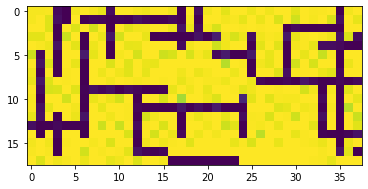

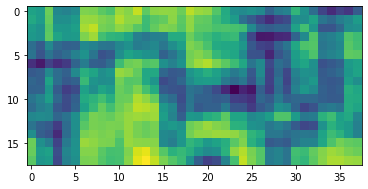

0.5565891472868217


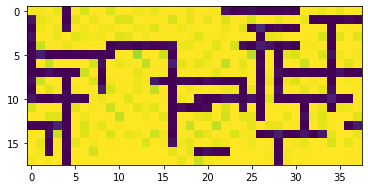

In [65]:
from matplotlib import pyplot as plt

picid1 = 100
picid2 = 50
i1 = truthpics[picid1]
i2 = datapics[picid2] 
input_data = np.expand_dims(np.stack((i1,i2),axis=2),axis=0)
plt.imshow(i1)
plt.show()
plt.imshow(i2)
plt.show()
plt.imshow(truthpics[picid2])
print(similarity(i1,truthpics[picid2]))

In [66]:
model.predict(input_data)


array([[0.5568269]], dtype=float32)

# 正例

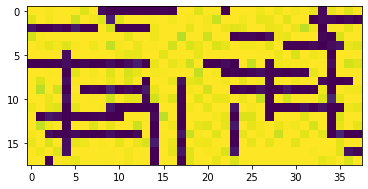

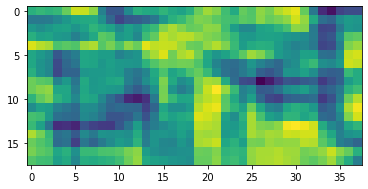

1.0


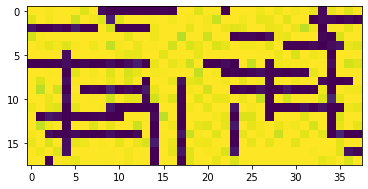

In [71]:
from matplotlib import pyplot as plt

i1 = truthpics[300]
i2 = datapics[300]         
input_data = np.expand_dims(np.stack((i1,i2),axis=2),axis=0)
plt.imshow(i1)
plt.show()
plt.imshow(i2)
plt.show()
plt.imshow(truthpics[300])
print(similarity(i1,truthpics[300]))

In [72]:
model.predict(input_data)


array([[1.008199]], dtype=float32)

# 测试：寻找某相似度的例子

found sim: 0.5699248120300752 number: 9280


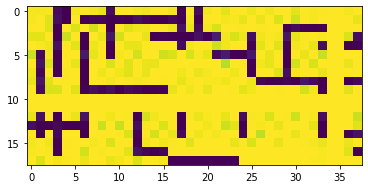

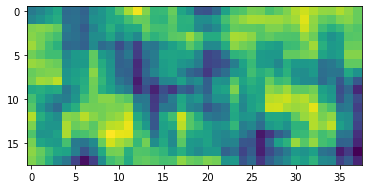

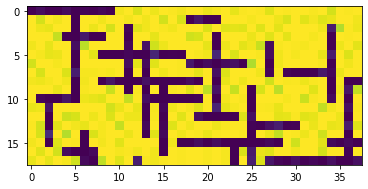

In [75]:
from matplotlib import pyplot as plt

picid1 = 100
picid2 = 0
desire_sim = 0.57
best_sim = 1
i1 = truthpics[picid1]
for i in range(PIC_NUM):
  if(i==picid1):continue
  sim = similarity(i1,truthpics[i])
  if(abs(sim-desire_sim)<best_sim):
    best_sim=abs(sim-desire_sim)
    picid2=i
    
print('found sim:',similarity(truthpics[picid2],i1),'number:',picid2)
i2 = datapics[picid2] 
input_data = np.expand_dims(np.stack((i1,i2),axis=2),axis=0)
plt.imshow(i1)
plt.show()
plt.imshow(i2)
plt.show()
plt.imshow(truthpics[picid2])

In [76]:
model.predict(input_data)

array([[0.57224935]], dtype=float32)

(array([4.600e+01, 6.340e+02, 3.137e+03, 7.603e+03, 9.410e+03, 6.259e+03,
        2.314e+03, 5.340e+02, 5.800e+01, 4.000e+00]),
 array([0.49770291, 0.51716339, 0.53662387, 0.55608434, 0.57554482,
        0.5950053 , 0.61446578, 0.63392626, 0.65338674, 0.67284721,
        0.69230769]),
 <a list of 10 Patch objects>)

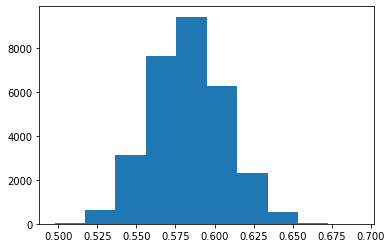

In [46]:
from matplotlib import pyplot as plt

picid1 = 100
i1 = truthpics[picid1]
simdata = []
for i in range(PIC_NUM):
  if(i==picid1):continue
  simdata.append(similarity(i1,truthpics[i]))
plt.hist(simdata)

# 对随机生成的图片进行验证

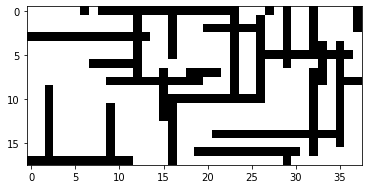

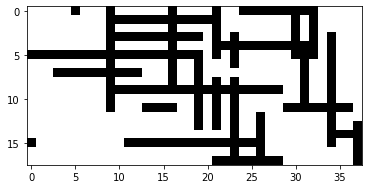

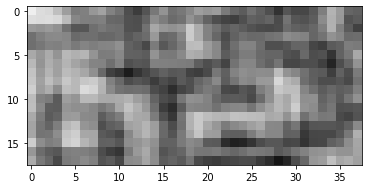

0.512779552715655
[[1.008199]]


In [127]:

import random
def gen_img():
  DIRS = [[-1,0],[1,0],[0,-1],[0,1]]
  imgnew = np.ones((XLEN,YLEN,3),dtype=np.uint8)*255
  for i in range(0,LINENUM):
      while True:
          x = int(random.random() * XLEN)
          y = int(random.random() * YLEN)
          dip = int(random.random()*4) 
          di = DIRS[dip]
          cross = 0
          value = int(random.random()*LEN)+4
          for j in range(value):
              ix = x + di[0] * j
              iy = y + di[1] * j
              if ix < 0 or ix >= XLEN or iy < 0 or iy >= YLEN: break
              if imgnew[ix][iy][0] == 0: cross += 1
          if cross >= 3: continue
          if cross != 1 and random.random() < 0.5: continue

          adj = 0
          erp = 0
          for p in range(4):
              if p == dip: continue
              for j in range(value):
                  ix = x + DIRS[p][0] + di[0] * j
                  iy = y + DIRS[p][1] + di[1] * j
                  if ix < 0 or ix >= XLEN or iy < 0 or iy >= YLEN: break
                  if imgnew[ix][iy][0] == 0: adj += 1
                  else: adj = 0
                  if adj >= 3:
                      erp = 1
                      break
              if erp == 1:break
          if erp == 1:continue

          for j in range(value):
              ix = x + di[0] * j
              iy = y + di[1] * j
              if ix < 0 or ix >= XLEN or iy < 0 or iy >= YLEN: break
              imgnew[ix][iy][0] = 0
              imgnew[ix][iy][1] = 0
              imgnew[ix][iy][2] = 0
          break  
  return imgnew

im1 = gen_img()
im2 = gen_img()
plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()
def add_noize(imgnew):
  noize = np.random.normal(-80, 80, (XLEN,YLEN))
  noizes = np.stack((noize, noize, noize),axis = 2)
  imgnoize = np.clip(imgnew + noizes, 0, 255).astype(np.uint8)
  imblur = cv2.blur(imgnoize,(3,3))
  return imblur
imnoize1 = add_noize(im1)
plt.imshow(imnoize1)
plt.show()
print(similarity(im1,im2))
input_data=np.expand_dims(np.stack((im1[:,:,0]/255.0, imnoize1[:,:,0]/255.0),axis=2),axis=0)
#input_data=np.expand_dims(np.stack((im1[:,:,0]/255.0, imnoize1[:,:,0]/255.0),axis=2),axis=0)
print(model.predict(input_data))  

In [101]:
!pip install deap
import matplotlib.image as mpimg  # mpimg 用于读取图片
import numpy as np
from scipy import ndimage
from skimage.measure import block_reduce, compare_mse
import os
from random import random
import math
from deap import base, creator, tools, algorithms


In [0]:
YLEN = 38
XLEN = 18
LEN = 13
#DIRS = [[[-1,-1],[-1,0]],[[-1,1],[0,1]]]
DIRS = [[[-1,0],[1,0]],[[0,-1],[0,1]]]

def genetic_genimg(individual):
    #imgnew = np.copy(imggen)
    imgnew = np.ones((XLEN,YLEN,3),dtype=np.uint8)*255
    for i in range(0,30*15,15):
        value = 0
        for j in range(13):
            value *= 2
            value += individual[i + j]
        x = value % XLEN
        value = math.floor(value / XLEN)
        y = value % YLEN
        value /= YLEN
        dir = DIRS[individual[i + 13]][individual[i + 14]]
        for j in range(math.floor(value)+4):
            ix = x + dir[0] * j
            iy = y + dir[1] * j
            if ix < 0 or ix >= XLEN or iy < 0 or iy >= YLEN: break
#            imgnew[ix][iy][0] += int((200 - imgnew[ix][iy][0])/2)
#            imgnew[ix][iy][1] += int((200 - imgnew[ix][iy][1])/2)
#            imgnew[ix][iy][2] += int((200 - imgnew[ix][iy][2])/2)
            r = 0.8
#            imgnew[ix][iy][0] = int( imgnew[ix][iy][0] * r)
#            imgnew[ix][iy][1] = int( imgnew[ix][iy][1] * r)
#            imgnew[ix][iy][2] = int( imgnew[ix][iy][2] * r)
            imgnew[ix][iy][0] = 0
            imgnew[ix][iy][1] = 0
            imgnew[ix][iy][2] = 0
    return imgnew


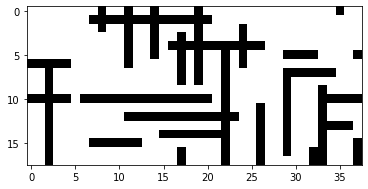

[[1.008199]]


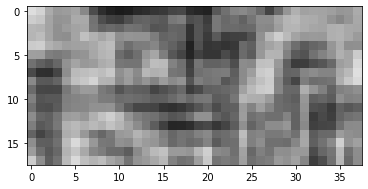

In [129]:
imgtruth = gen_img()
imgnoize = add_noize(imgtruth)
plt.imshow(imgtruth)
plt.show()
plt.imshow(imgnoize)
input_data=np.expand_dims(np.stack((imgtruth[:,:,0]/255.0, imgnoize[:,:,0]/255.0),axis=2),axis=0)
print(model.predict(input_data))

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg                	min                	max              
0  	50    	0.46099263429641724	0.42156994342803955	0.509445309638977
1  	28    	0.43974196910858154	0.4159983992576599 	0.48272889852523804
2  	32    	0.42867064476013184	0.4073159694671631 	0.4593803882598877 
3  	32    	0.42334315180778503	0.40669357776641846	0.4452861547470093 
4  	34    	0.41810059547424316	0.3854430317878723 	0.46580231189727783
5  	34    	0.40712428092956543	0.37673699855804443	0.4266812801361084 
6  	32    	0.3999420404434204 	0.37673699855804443	0.4315856695175171 
7  	22    	0.38967978954315186	0.37673699855804443	0.4137842655181885 
8  	27    	0.3860520124435425 	0.3695390820503235 	0.44195157289505005
9  	20    	0.3802330791950226 	0.3642348051071167 	0.40175771713256836
10 	33    	0.3775618374347687 	0.3642348051071167 	0.41423094272613525
11 	34    	0.3750159740447998 	0.3612181544303894 	0.401369571685791  
12 	38    	0.3703750967979431 	0.3613412380218506 	0.39442163705825806
13 	34    

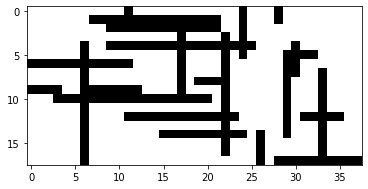

In [131]:
import random

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=30*15)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    imgnew = genetic_genimg(individual)
    input_data=np.expand_dims(np.stack((imgnew[:,:,0]/255.0, imgnoize[:,:,0]/255.0),axis=2),axis=0)
    diff = model.predict(input_data)
    return [abs(diff-1),]



toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=3)


def genetic_train():
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=3001, stats=stats, halloffame=hof,verbose=True)


    return pop, logbook, hof

pop, log, hof = genetic_train()
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")


individual = hof[0]
imgout = genetic_genimg(individual) 
plt.imshow(imgout)
